### Work division
#### The work for this notebook is done and compiled by Nemish Murawat.

#### Required Libraries

In [1]:
# Import Requirements
import pandas as pd
from tqdm import tqdm as tq
import numpy as np
import matplotlib.pyplot as plt
from pre_processing_posts import pre_processing_posts as pre_posts
import datetime
import random

### RQ3.1 What is the most common time in which users publish their posts?

#### *Approach*:-

##### - In order to find the most common time for all the posts made by the users in Posts dataset:
>##### - I read the *Instagram_Posts.csv* dataset in chunks to be more efficient in the analysis and just read the time stamp columns.
>##### - I drop the rows in read chunk which has NaN values for the CTS columns
>##### - I convert the cts column into datetime object and just get the hour of the time of post to have a better representation of the number of posts in an interval. 
>>##### -The precision of bining the values should be an hour to make a more generalised outcome. 
>>##### - If we go for precision in minutes or seconds the results would be more voliatile and hence have chosen a hour as measure of time intervals
>##### - Then I used numpy histogram function to calculate get the count of number of posts in every interval.
>##### - I add the histogram values for all the chunks to get the overall numbers for the complete dataset

In [2]:

for i,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_posts.csv',usecols=['cts'],sep='\t',chunksize=1000000))):
    chunk=chunk.dropna()
    df_time=pd.DatetimeIndex(chunk.cts).hour
    if i==0:
        n,bins=np.histogram(df_time,bins=np.arange(0,25))
        n=np.array(n)
    else:
        n1,bins=np.histogram(df_time,bins=np.arange(0,25))
        n1=np.array(n1)
        n=n+n1


43it [54:21, 75.84s/it]


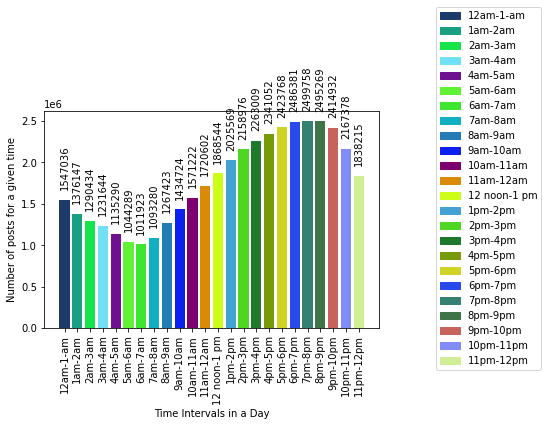

The most common time the users publish their posts is 7pm-8pm with 2499758 numbers of user posting


In [3]:


tic_label=['12am-1-am']
for i in range(0,11):
    tic_label.append(str(i+1)+'am'+'-'+str(i+2)+'am')
tic_label.append('12 noon-1 pm')
for i in range(0,11):
    tic_label.append(str(i+1)+'pm'+'-'+str(i+2)+'pm')
fig, ax = plt.subplots()
colors=[]
for i in range(24):
    colors.append( (random.random(), random.random(), random.random()))

p1=ax.bar(bins[1::],n,tick_label=tic_label,color=colors,label=tic_label)
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i,label in enumerate(tic_label)]
plt.legend(handles,tic_label,bbox_to_anchor=(1,0.5,0.5,1))
ax.bar_label(p1,labels=np.round(n),label_type='edge',rotation=90,padding=10)
plt.xticks(rotation=90)
plt.xlabel('Time Intervals in a Day')
plt.ylabel('Number of posts for a given time')
plt.show()
print('The most common time the users publish their posts is {0} with {1} numbers of user posting'.format(tic_label[np.argmax(n)],np.amax(n)))

### RQ3.2 Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.

#### *Approach*:-
##### Step-1: In order to create a function that plots the number of intervals I divided the tasks into three sub functions.
>#####  Time_in_seconds: This function iterates over the different time stamps present and converts the time stamps to seconds .
>>##### I iterate over the different time stamp and convert them into datetime objects.
>>##### While converting to datetime objects I just read the time-stamp(only time). The datetime objects assign it's date as [1/1/1900].
>>##### I used this logic as different time-stamps has different dates spread all over the year and I just wanted to focus on time to estimate common time of posting.
>>##### Finally,I output a list of time-stamps in seconds.


In [21]:
def time_in_seconds(time_list:list):
    
    ''' Args: It takes a list of tuples of the different time intervals as input. Suppose the size of list is n and each tuple is made of two elements,total elements are n*2.
    
        Returns: A list of time converted into seconds for every time-stamp passed to the function.Total size is n*2.
        
        Objective: This function iterates over the different time stamps present and converts the time stamps to seconds . Finally appends to the final list. '''
    
    seconds=[]

    for i in time_list:
        for l,j in enumerate(i):
            date_time = datetime.datetime.strptime(j, "%H:%M:%S")
            a_timedelta = date_time - datetime.datetime(1900, 1, 1)
            if l==0:
                seconds.append(a_timedelta.total_seconds())
            else:
                seconds.append(a_timedelta.total_seconds()+1)
            seconds.sort()
    return seconds
        


##### Step-2: post_interval(time_list:list)
>##### It iterates over the posts datasets which is read in chunks and then give the total counts for all the posts in the different time intervals
>##### I perform operation on the chunks to extract the time-in-seconds from time-stamp(time-only) after converting them to date-time objects.
>##### I use numpy histogram function to calculate the number of posts in different time_intervals to get the count for that chunk
>##### I repeat the same for all the chunks.


In [22]:
def post_interval(time_list:list):
    
    ''' Args: It takes a list of tuples of the different time intervals as input. Suppose the size of list is n and each tuple is made of two elements,total elements are n*2.
    
        Returns: It returns two values:
                        1.counts of the posts in the given interval(n)
                        2. returns the bins used to caluculate the counts in the different time-intervals(bins_custom)
        
        Objective: This function uses time_in_seconds functions to calculate the different time intervals converted to seconds which is used further as the bins(histogram function).
        It iterates over the posts datasets which is read in chunks and then give the total counts for all the posts in the different time intervals'''
    
    bins_custom=time_in_seconds(time_list)
    for i,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_posts.csv',usecols=['cts'],sep='\t',chunksize=100000))):
        chunk=chunk.dropna()
        
        # try:
        df_time=pd.DatetimeIndex(chunk.cts).hour*3600+pd.DatetimeIndex(chunk.cts).minute*60+pd.DatetimeIndex(chunk.cts).second
        df_time=df_time.values
        # except:
        #     df.info()
        #     print(df[df.cts.isna()])
        if i==0:
            n,bins=np.histogram(df_time,bins=bins_custom)
            n=np.array(n)
        else:
            
            n1,bins=np.histogram(df_time,bins=bins_custom)
            n1=np.array(n1)
            n=n+n1
    return n,bins_custom

##### Step-3: plot_bar_interval(time_list:list,n:np.array):

>##### I used the obtained counts from the post_interval function and the time_list to plot a Horizontal bar plot

In [14]:
def plot_bar_interval(time_list:list,n:np.array):
    ''' Args: It takes a list of tuples of the different time intervals as input. Suppose the size of list is n and each tuple is made of two elements,total elements are n*2.
              It also takes an input as numpy array which represents the histogram counts for the required time-intervals passed as list of tuples.
    
        Returns: The Horizontal bar plot 
        
        Objective: This function plots the horizontal barplot for the obtained counts from the post_interval function for all the time intervals. Note it plots the 
        time-intervals in acscending orders '''
    
    
    
    Y=np.arange(0,len(time_list))
    x=[x for _, x in sorted(zip(Y, time_list), key=lambda pair: pair[1][1])]
    labels=[str(j[0])+'-'+str(j[1]) for j in x]
    fig, ax = plt.subplots()
    colors=[]
    for i in range(len(n[0::2])):
        colors.append( (random.random(), random.random(), random.random()))
    p1=ax.barh(width=n[0::2],y=labels,color=colors)
    plt.xticks(rotation=90)
    ax.bar_label(p1,labels=np.round(n[0::2]),label_type='edge',padding=10)
    plt.xlabel('Number of Posts in the requested time interval')
    plt.ylabel(' The provided time intervals')
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i,label in enumerate(labels)]
    plt.legend(handles,labels,bbox_to_anchor=(1,-0.5,0.5,1))

##### Step-4: post_interval_plot(time_list:list)

>##### This function uses all the three function time_in_seconds,post_interval,plot_bar_interval and gives an output a plot of counts of posts for passed intervals.

In [20]:
def post_interval_plot(time_list:list):
     ''' Args: It takes a list of tuples of the different time intervals as input. Suppose the size of list is n and each tuple is made of two elements,total elements are n*2.
              
    
        Returns: The Horizontal bar plot.Returns no variable.
        
        Objective: This function uses all the three function time_in_seconds,post_interval,plot_bar_interval. This outputs a horizontal bar plot with number of posts for all the 
        asked intervals'''
        
     bins_custom=time_in_seconds(time_list)
     n,bins_custom=post_interval(time_list)
     plot_bar_interval(time_list,n)

### RQ3.3 Use the function that you created in the previous literal to plot the number of posts between the following time intervals:
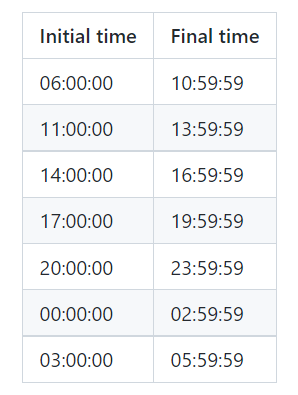

#### *Approach*:-
##### I use the previous implemented function to answer this part.It is pretty straightforward.


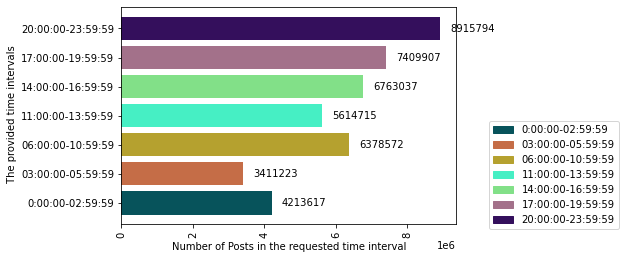

In [12]:
time_list=[('06:00:00','10:59:59'),('11:00:00','13:59:59'),('14:00:00','16:59:59'),('17:00:00','19:59:59'),('20:00:00','23:59:59'),('0:00:00','02:59:59'),('03:00:00','05:59:59')]
post_interval_plot(time_list)
